In [1]:
import random
from collections import OrderedDict, defaultdict

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm


# To ensure the reproducibility, we will control the seed of random generators:

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

In this tutorial, we will use CIFAR-10 as our target dataset. This dataset contains images from 10 classes, where each image is of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

In [3]:
transforms = {
    "train": Compose([
        RandomCrop(32, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}

dataset = {}
for split in ["train", "test"]:
    dataset[split] = CIFAR10(
        root="data/cifar10",
        train=(split=="train"),
        download=True,
        transform=transforms[split],
    )

Files already downloaded and verified
Files already downloaded and verified


We can visualize a few images in the dataset and their corresponding class labels:

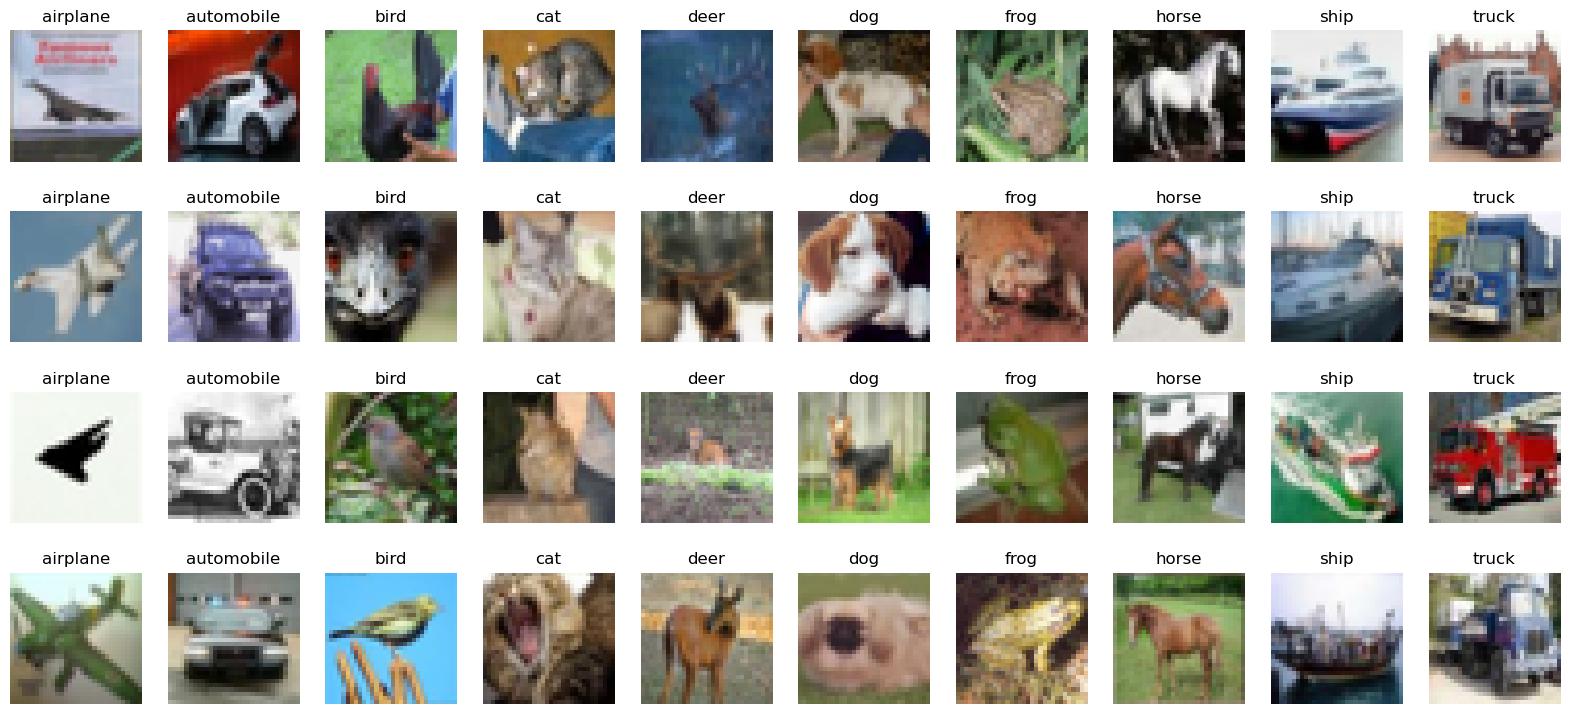

In [4]:
samples = [[] for _ in range(10)]
for im, label in dataset['test']:
    if len(samples[label]) < 4:
        samples[label].append(im)

plt.figure(figsize=(20, 9))
for idx in range(40):
    label = idx%10
    im = samples[label][idx//10]

    # to RGB
    im = im.permute(1, 2, 0)
    label = dataset['test'].classes[label]

    # vis im
    plt.subplot(4, 10, idx+1)
    plt.imshow(im)
    plt.title(label)
    plt.axis('off')
plt.show()
    

To train a neural network, we will need to feed data in batches. We create data loaders with batch size of 512:

In [5]:
dataflow = {}
for split in ['train', 'test']:
    dataflow[split] = DataLoader(
        dataset[split],
        batch_size=512,
        shuffle=(split== 'train'),
        num_workers=0,
        pin_memory=True,        
    )

In [6]:
# print data type and shape for the training data

for inputs, targets in dataflow['train']:
    print(f'{inputs.dtype}, {inputs.shape}')
    print(f'{targets.dtype}, {targets.shape}')
    break

torch.float32, torch.Size([512, 3, 32, 32])
torch.int64, torch.Size([512])


In [7]:
# Check MPS (Metal Performance Shaders) 

print(torch.backends.mps.is_available())  # Should print True if MPS is available
print(torch.backends.mps.is_built())     # Should print True if MPS backend is built

True
True


Model: VGG-11 classification network

In [8]:
class VGG(nn.Module):
    ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

    def __init__(self) -> None:
        super().__init__()

        layers = []
        counts = defaultdict(int)

        def add(name: str, layer: nn.Module) -> None:
            layers.append((f"{name}{counts[name]}", layer))
            counts[name] += 1

        in_channels = 3
        for x in self.ARCH:
            if x != 'M':
                # conv-bn-relu
                add('conv', nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
                add("bn", nn.BatchNorm2d(x))
                add("relu", nn.ReLU(True))
                in_channels = x
            else:
                # maxpoool
                add('pool', nn.MaxPool2d(2))

        self.backbone = nn.Sequential(OrderedDict(layers))
        self.classifier = nn.Linear(512, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.backbone(x)

        # [N, 512, 2, 2] -> [N, 512]
        x = x.mean([2, 3])

        # [N, 512] -> [N, 10]
        x = self.classifier(x)
        return x

assert torch.backends.mps.is_available()

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = VGG().to(device)            
                    
                
    
    

In [ ]:
print(model.backbone)


In [ ]:
print(model.classifier)

In [9]:
# number of parameters
num_params = 0
for param in model.parameters():
    if param.requires_grad:
        num_params += param.numel()
print(f"#Params: {num_params}")

#Params: 9228362


In [10]:
# Number MACs
num_macs = profile_macs(model, torch.zeros(1, 3, 32, 32).to(device))
print(f"#MACS={num_macs}")

#MACS=606164480


This model has 9.2M parameters and requires 606M MACs for inference. We will work together in the next few labs to improve its efficiency.

# Optimization

In [11]:
criterion = nn.CrossEntropyLoss()

In [12]:
optimizer = SGD(
    model.parameters(),
    lr=0.4,
    momentum=0.9,
    weight_decay=5e-4,)

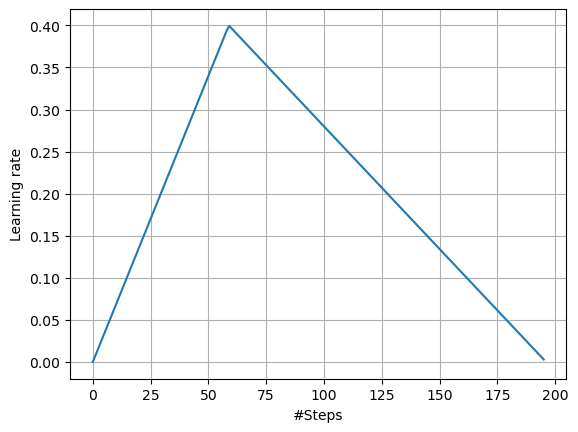

In [13]:
num_epochs = 2
steps_per_epoch = len(dataflow['train'])

lr_lambda = lambda step: np.interp(
    [step/steps_per_epoch],
    [0, num_epochs * 0.3, num_epochs],
    [0, 1, 0]
)[0]

steps = np.arange(steps_per_epoch * num_epochs)
plt.plot(steps, [lr_lambda(step) * 0.4 for step in steps])
plt.xlabel('#Steps')
plt.ylabel('Learning rate')
plt.grid('on')
plt.show()

scheduler = LambdaLR(optimizer, lr_lambda)

#Training

In [15]:
def train(model: nn.Module,
          dataflow: DataLoader,
          criterion: nn.Module,
          optimizer: Optimizer,
          scheduler: LambdaLR,
         ) -> None:
    model.train()

    for inputs, targets in tqdm(dataflow, desc='train', leave=False):
        inputs = inputs.to(device)
        targets = targets.to(device)

        # reset the gradients
        optimizer.zero_grad()

        # forward
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # backward propagation
        loss.backward()

        # update optimizer and LR scheduler
        optimizer.step()
        scheduler.step()
        

In [ ]:
# Evaluation

In [19]:
@torch.inference_mode()
def evaluate(model: nn.Module,
            dataflow: DataLoader) -> float:
    model.eval()

    num_samples = 0
    num_correct = 0

    for inputs, targets in tqdm(dataflow, desc='eval', leave=False):
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        outputs = outputs.argmax(dim=1)

        num_samples += targets.size(0)
        num_correct += (outputs == targets).sum()

    return (num_correct/num_samples * 100).item()      
    

# train the model using Mac MPS

In [20]:
for epoch_num in tqdm(range(1, num_epochs + 1)):
    train(model, dataflow['train'], criterion, optimizer, scheduler)
    metric = evaluate(model, dataflow['test'])
    print(f'Epoch {epoch_num}: {metric}')

  0%|          | 0/2 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: 66.08999633789062


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2: 65.93000030517578


# Visualization 

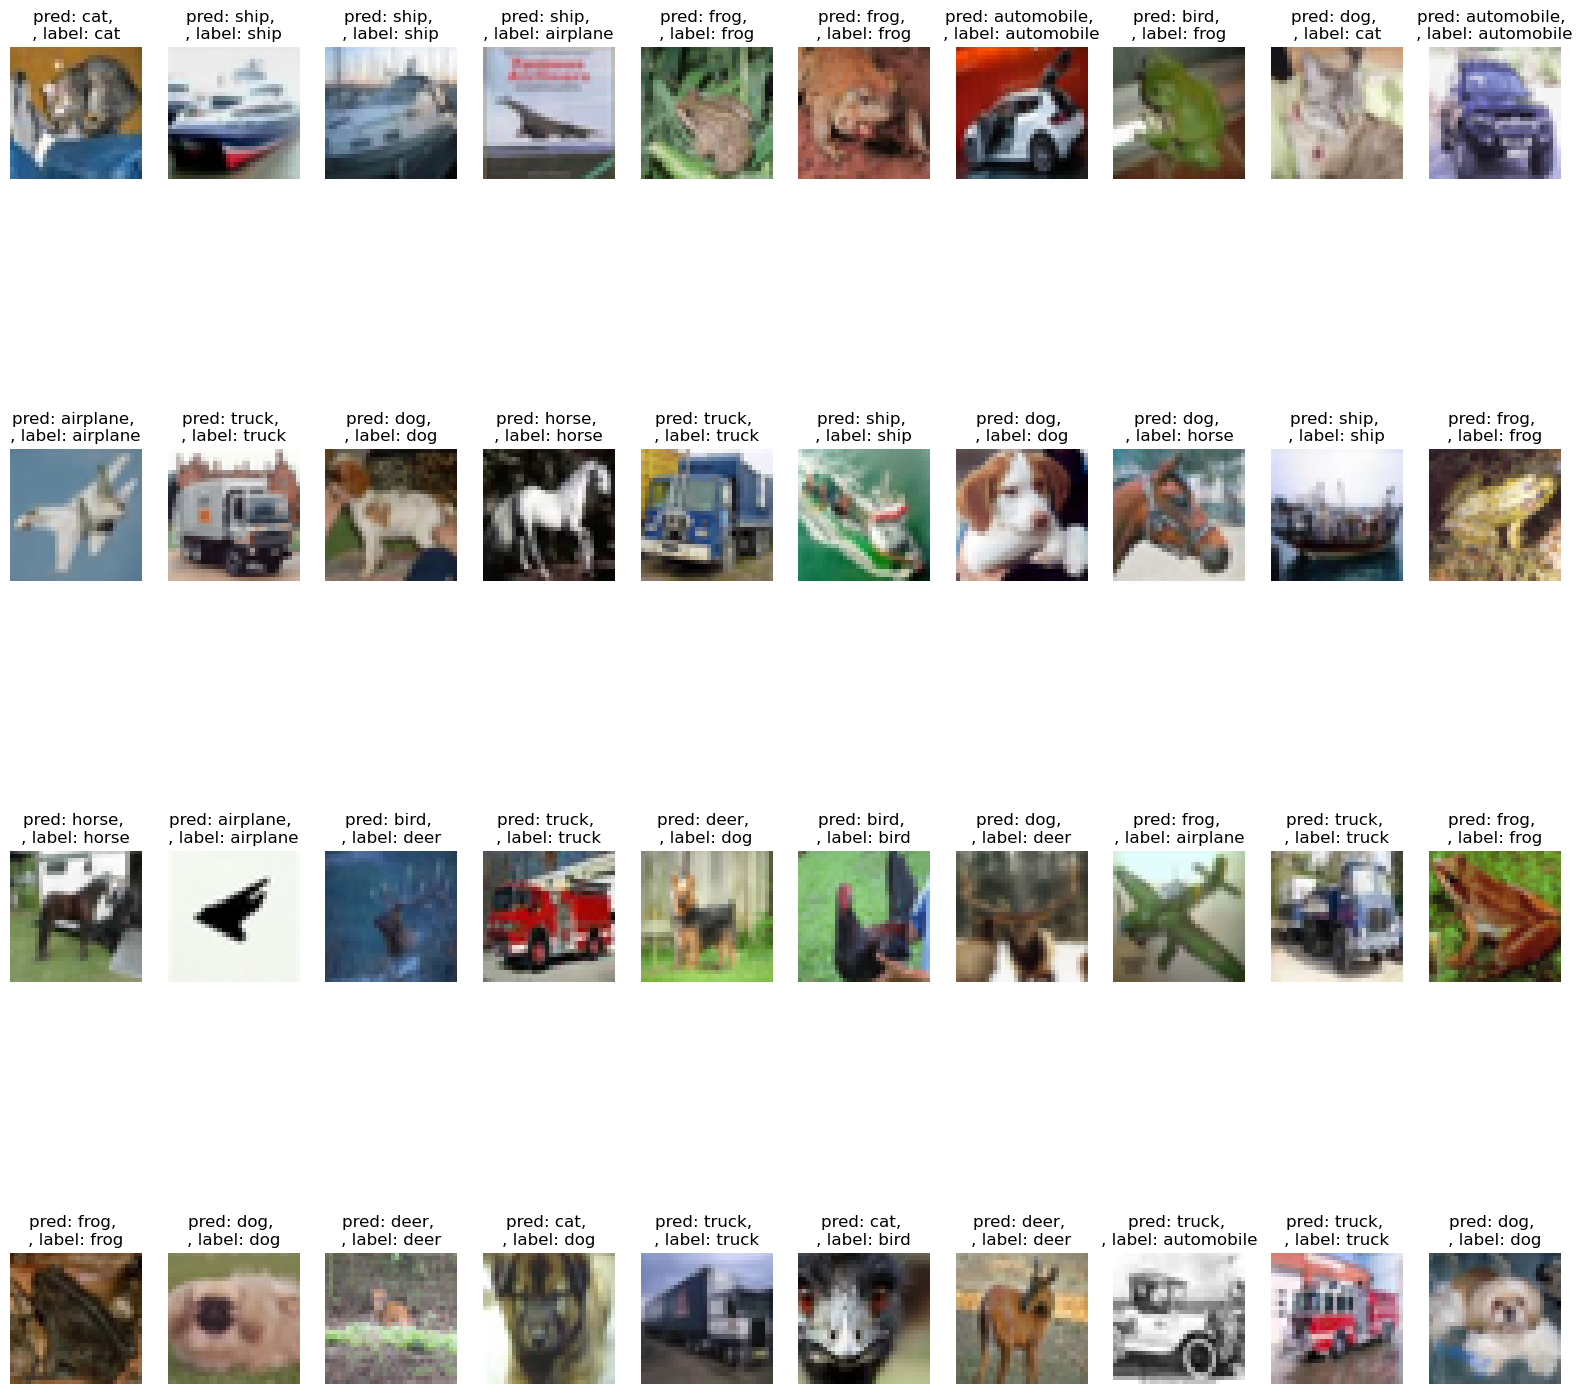

In [23]:
plt.figure(figsize=(20, 20))
for idx in range(40):
    im, label = dataset['test'][idx]

    # model inference
    model.eval()
    with torch.inference_mode():
        pred = model(im.unsqueeze(dim=0).to(device))
        pred = pred.argmax(dim=1)
        
    im = im.permute(1, 2, 0)

    # pred index to name
    pred = dataset['test'].classes[pred]
    label = dataset['test'].classes[label]

    # vis img
    plt.subplot(4, 10, idx+1)
    plt.imshow(im)
    plt.title(f'pred: {pred}, \n, label: {label}')
    plt.axis('off')
plt.show()
    